# Stroke Prediction

## Project Overview

### Import Libraries

In [163]:
# Import libraries
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

from mlens.ensemble import SuperLearner

import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn theme
sns.set()
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.set_palette("Dark2")

# Set seed
seed = 42
np.random.seed(seed)

### Import Data

In [92]:
# Import data
raw_train_df = pd.read_csv("data/train.csv")
raw_test_df = pd.read_csv("data/test.csv")

In [63]:
raw_test_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,15304,Female,57.0,0,0,Yes,Private,Rural,82.54,33.4,Unknown
1,15305,Male,70.0,1,0,Yes,Private,Urban,72.06,28.5,Unknown
2,15306,Female,5.0,0,0,No,children,Urban,103.72,19.5,Unknown
3,15307,Female,56.0,0,0,Yes,Govt_job,Urban,69.24,41.4,smokes
4,15308,Male,32.0,0,0,Yes,Private,Rural,111.15,30.1,smokes
...,...,...,...,...,...,...,...,...,...,...,...
10199,25503,Female,27.0,0,0,No,Private,Urban,75.77,17.6,never smoked
10200,25504,Male,49.0,0,0,Yes,Private,Urban,102.91,26.7,Unknown
10201,25505,Female,3.0,0,0,No,children,Rural,104.04,18.3,Unknown
10202,25506,Male,31.0,0,0,Yes,Private,Urban,82.41,28.7,never smoked


In [5]:
# View data
raw_train_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0
...,...,...,...,...,...,...,...,...,...,...,...,...
15299,15299,Female,22.0,0,0,No,Govt_job,Urban,72.63,19.5,never smoked,0
15300,15300,Female,46.0,1,0,Yes,Private,Urban,101.19,32.1,never smoked,0
15301,15301,Female,75.0,0,0,Yes,Self-employed,Urban,87.69,26.2,never smoked,0
15302,15302,Male,46.0,0,0,Yes,Private,Rural,101.13,22.5,Unknown,0


In [109]:
# Create copies of the raw data for exploration
train_cp = raw_train_df.copy()
test_cp = raw_test_df.copy()

## Data Description

The target variable in this dataset is called **stroke**, a binary variable indicating whether or not an individual has had a stroke. This data contains the following features:
- **id**: unique identifier
- **gender**: "male", "female", or "other"
- **age**: age (in years)
- **hypertension**: whether or not the patient has hypertension (binary)
- **heart_disease**: whether or not the patient has heart disease (binary)
- **ever_married**: whether or not the patient was ever married (binary)
- **work_type**: "children", "govt_jov", "never_worked", "private", "self-employed"
- **residence_type**: "rural", "urban"
- **avg_glucose_level**: average glucose level in blood
- **bmi**: body mass index
- **smoking_status**: "formerly smoked", "never smoked", "smokes", "unknown"


In [6]:
# Check data types and missing values
train_cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15304 entries, 0 to 15303
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 15304 non-null  int64  
 1   gender             15304 non-null  object 
 2   age                15304 non-null  float64
 3   hypertension       15304 non-null  int64  
 4   heart_disease      15304 non-null  int64  
 5   ever_married       15304 non-null  object 
 6   work_type          15304 non-null  object 
 7   Residence_type     15304 non-null  object 
 8   avg_glucose_level  15304 non-null  float64
 9   bmi                15304 non-null  float64
 10  smoking_status     15304 non-null  object 
 11  stroke             15304 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.4+ MB


In [7]:
# Quick stats: Continuous variables
# Exclude object dtypes: gender, ever_married, work_type, residence_type, and smoking_status
round(train_cp.describe(exclude = "object"), 2)

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,15304.00,15304.00,15304.00,15304.00,15304.00,15304.00,15304.00
mean,7651.50,41.42,0.05,0.02,89.04,28.11,0.04
std,4418.03,21.44,0.22,0.15,25.48,6.72,0.20
min,0.00,0.08,0.00,0.00,55.22,10.30,0.00
25%,3825.75,26.00,0.00,0.00,74.90,23.50,0.00
50%,7651.50,43.00,0.00,0.00,85.12,27.60,0.00
75%,11477.25,57.00,0.00,0.00,96.98,32.00,0.00
max,15303.00,82.00,1.00,1.00,267.60,80.10,1.00


First look notes:
- Minimum age is 0.08 - unless this study included newborns, this is probably dirty data
- Minimum BMI is 10.30 - also probably dirty data

In [9]:
# Quick stats: categorical variables
# Exclude integers and floats: id, age, hypertension, heart_disease, avg_glucose_level, bmi, stroke
train_cp.describe(exclude = ["float", "int64"])

,gender,ever_married,work_type,Residence_type,smoking_status
count,15304,15304,15304,15304,15304
unique,3,2,5,2,4
top,Female,Yes,Private,Rural,never smoked
freq,9446,10385,9752,7664,6281


## Data Exploration

In [38]:
# Quick view of distribution of target: stroke
raw_train_df.groupby("stroke")["stroke"].count()

stroke
0    14672
1      632
Name: stroke, dtype: int64

Very unbalanced dataset. There are only 632 cases out of 15 304 data points. 

A [post on the discussion forum](https://www.kaggle.com/competitions/playground-series-s3e2/discussion/377875) for this dataset suggests adding valid cases from the original dataset to this dataset for training. There are 249 cases in that dataset, of which 40 BMI values are null. Taking complete cases leaves 209 additional cases that can be included in our model here.

In [4]:
# Add cases from original dataset to our training dataframe
df_orig = pd.read_csv("data/original_stroke_data.csv")

# Remove null values
df_orig = df_orig.dropna()

# Identify cases only (stroke = 1)
df_orig_stroke_cases = df_orig[df_orig[['stroke']].all(1)]

# Append to our training data
train_cp = pd.concat([train_cp, df_orig_stroke_cases])


In [40]:
# Number of cases in original data
df_orig.groupby("stroke")["stroke"].count()

stroke
0    4700
1     209
Name: stroke, dtype: int64

In [41]:
# Quick view of distribution of target: stroke (with cases from original dataset)
train_cp.groupby("stroke")["stroke"].count()

stroke
0    14672
1      841
Name: stroke, dtype: int64

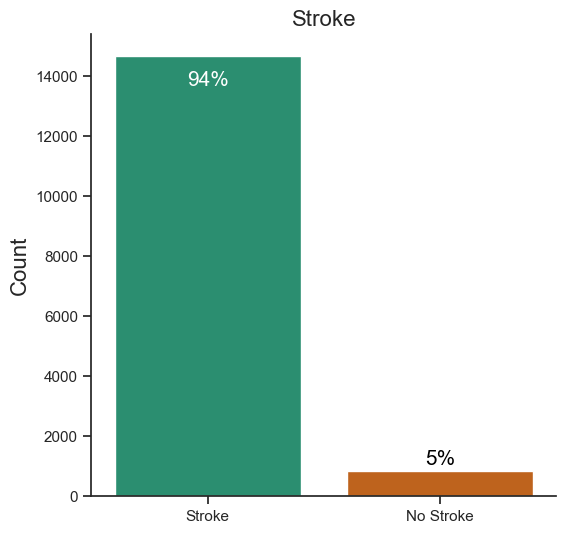

In [42]:
# Visualizing distribution of target: stroke (with cases from original dataset)
stroke_group_perc = pd.DataFrame()
stroke_group_perc["Count"] = train_cp.groupby("stroke")["stroke"].count()
stroke_group_perc["Percent"] = stroke_group_perc["Count"] / stroke_group_perc["Count"].sum() * 100
stroke_group_perc["Percent"] = stroke_group_perc["Percent"].astype(int)

# Identify percent categories
stroke_case = stroke_group_perc["Percent"].iloc[0]
stoke_none = stroke_group_perc["Percent"].iloc[1]

# Plot counts & percentages on a bar chart
plt.figure(figsize = (6, 6))
sns.countplot(data = train_cp, x = "stroke")

plt.annotate(str(stroke_case)+"%", xy=(0,stroke_group_perc["Count"].iloc[0]-1000), color = 'white', size = 15, ha = 'center')
plt.annotate(str(stoke_none)+"%", xy=(1, stroke_group_perc["Count"].iloc[1]+200), color = 'black', size = 15, ha = 'center')

plt.xticks([0, 1], labels = ["Stroke", "No Stroke"])
plt.ylabel("Count", fontsize=16)
plt.xlabel("")
plt.title("Stroke", fontsize=16)
plt.show()

In [110]:
# Quick view of distribution of feature: gender
train_cp.groupby("gender")["gender"].count()

gender
Female    9446
Male      5857
Other        1
Name: gender, dtype: int64

In [111]:
# Replace 'other' gender with 'Female'
train_cp["gender"].replace("Other", "Female", inplace = True)

In [112]:
# Quick view of distribution of feature: gender (without 'other')
train_cp.groupby("gender")["gender"].count()

gender
Female    9447
Male      5857
Name: gender, dtype: int64

In [16]:
# Quick view of distribution of feature: residence type
train_cp.groupby("Residence_type")["Residence_type"].count()

Residence_type
Rural    7763
Urban    7749
Name: Residence_type, dtype: int64

In [17]:
# Quick view of distribution of feature: ever married
train_cp.groupby("ever_married")["ever_married"].count()

ever_married
No      4941
Yes    10571
Name: ever_married, dtype: int64

In [18]:
# Quick view of distribution of feature: work type
train_cp.groupby("work_type")["work_type"].count()

work_type
Govt_job         1561
Never_worked       42
Private          9879
Self-employed    1992
children         2038
Name: work_type, dtype: int64

## Data Modeling

We will be using an ensemble of 8 classification machine learning models. These 5 models are:
- Logisitic regression
- Decision trees
- SVM
- AdaBoost
- XGBoost
- LightGBM
- K Nearest Neighbors
- Random Forest

We will create a super learner ensemble which fits the ensemble using cross-validation. 

### Data Preparation

In [114]:
# Copy raw data to be used in modeling
train = raw_train_df.copy()
test = raw_test_df.copy()

In [ ]:
# Add cases from original dataset to our training dataframe
# Import original data
df_orig = pd.read_csv("data/original_stroke_data.csv")
# Remove null values
df_orig = df_orig.dropna()
# Identify cases only (stroke = 1)
df_orig_stroke_cases = df_orig[df_orig[['stroke']].all(1)]
# Append to our training data
train = pd.concat([train, df_orig_stroke_cases])

In [113]:
# Data cleaning steps
def data_cleaning_steps(df):
    # Replace 'Other' gender with 'Female'
    df["gender"].replace("Other", "Female", inplace = True)

    # Binary variable format check
    # Gender, Residence_type, and ever_married are binary variables that must be converted to the 0/1 format
    df["gender"].replace({"Male": 0, "Female": 1}, inplace = True)
    df["Residence_type"].replace({"Urban": 0, "Rural": 1}, inplace = True)
    df["ever_married"].replace({"No": 0, "Yes": 1}, inplace = True)

    # Return df
    return df

In [38]:
# Apply data cleaning steps
train = data_cleaning_steps(train)

In [39]:
# Split features and target
train_features = train.drop(["stroke", "id"], axis = 1)
train_target = train["stroke"].copy()

In [53]:
train_target.describe()

count    15512.000000
mean         0.054216
std          0.226451
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: stroke, dtype: float64

In [82]:
def data_processing_steps(df):
    # Onehotencode categorical variables
    onehot_df = df[["work_type", "smoking_status"]]
    onehot = OneHotEncoder(drop = 'first', sparse = False)
    onehot_df = pd.DataFrame(onehot.fit_transform(onehot_df), columns = onehot.get_feature_names_out(["work_type", "smoking_status"]))

    # Add onehotencoder features back to train set
    df.reset_index(drop=True, inplace=True)
    df = pd.concat([df, onehot_df], axis = 1)

    # Remove redundant columns
    df = df.drop(["work_type", "smoking_status"], axis = 1)

    # Standardise continuous variables
    scaler = StandardScaler()
    df_scaled = df.copy()
    features_to_scale = df_scaled[["age", "avg_glucose_level", "bmi"]]
    features_to_scale = scaler.fit_transform(features_to_scale.values)
    df_scaled[["age", "avg_glucose_level", "bmi"]] = features_to_scale

    # Return final scaled df
    return df_scaled

In [41]:
# Apply data processing steps
train_features_scaled = data_processing_steps(train_features)

In [69]:
train_features_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15512 entries, 0 to 15511
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender                          15512 non-null  int64  
 1   age                             15512 non-null  float64
 2   hypertension                    15512 non-null  int64  
 3   heart_disease                   15512 non-null  int64  
 4   ever_married                    15512 non-null  int64  
 5   Residence_type                  15512 non-null  int64  
 6   avg_glucose_level               15512 non-null  float64
 7   bmi                             15512 non-null  float64
 8   work_type_Never_worked          15512 non-null  float64
 9   work_type_Private               15512 non-null  float64
 10  work_type_Self-employed         15512 non-null  float64
 11  work_type_children              15512 non-null  float64
 12  smoking_status_formerly smoked  

### Fitting the Model

In [193]:
# Get a list of models
def get_models():
    models = list()
    models.append(LogisticRegression())
    models.append(DecisionTreeClassifier())
    models.append(xgb.XGBClassifier())
    models.append(lgb.LGBMClassifier())
    models.append(AdaBoostClassifier())
    models.append(KNeighborsClassifier())
    models.append(RandomForestClassifier())
    models.append(SVC(probability=True))
    return models

In [197]:
def build_ensemble():
    ensemble = SuperLearner(random_state=seed, folds = 25, shuffle = True, verbose = 1)

    # Add models
    models = get_models()
    ensemble.add(models, proba = True)

    # Attach the final meta estimator
    ensemble.add(LogisticRegression(), meta = True, proba = True)
    
    return ensemble

In [198]:
# Build the super learer
ensemble = build_ensemble()

In [199]:
# Fit the super learner ensemble
ensemble.fit(train_features_scaled.values, train_target.values)


Fitting 2 layers


/Users/jobel/opt/anaconda3/envs/kaggle-playground-season3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[14:45:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
/Users/jobel/opt/anaconda3/envs/kaggle-playground-season3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label en

Fit complete                        | 00:04:10


SuperLearner(array_check=None, backend=None, folds=25,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=7270, shuffle=True,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=25, raise_on_ex...er=None)],
   n_jobs=-1, name='group-27', raise_on_exception=True, transformers=[])],
   verbose=0)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=42, sample_size=20, scorer=None, shuffle=True,
       verbose=1)

In [115]:
# Prepare test data for predictions
test = data_cleaning_steps(test)
test = data_processing_steps(test)

In [116]:
# Drop ID var
test_features = test.drop(["id"], axis = 1)

In [200]:
# Make predictions for test data
yhat = ensemble.predict_proba(test_features.values)


Predicting 2 layers
Predict complete                    | 00:00:03


In [121]:
# Get test ID var and append to predictions
test_ids = test[["id"]]

In [201]:
# Submission
submission = pd.concat([test_ids, pd.DataFrame(yhat[:,1])], axis = 1)
submission = submission.rename(columns = {0: 'stroke'})
submission.to_csv("data/submission.csv", index = False)